
# Momentum

**Momentum** is the fact that stocks that have performed
**relatively** well in the past continue to perform
**relatively** well in the future, and stocks that have performed
**relatively** poorly, continue to perform **relatively**
poorly.

A Momentum investment or “relative strength”
strategy buys stocks which have performed relatively
well in the past and sells (shorts) stocks which have performed
relatively poorly.
Over the **1963-1990** time period, Jegadeesh and Titman
(1993) found that a strategy that ranked stocks based on
their past 6 months to a year returns, and bought the top
10% and shorted the bottom 10% based on this ranking,
produced abnormal returns of 12% per year.


Momentum portfolios bet on **cross-sectional** continuation. That is, in a stock did well relative to others in the recent past, the bet is that will continue to do better than the average going forward.

In some ways momentum is the opposite of a value strategy , since value stocks are stocks that have had very low returns (how else they would be value?)

The difference is that value/growth focus on the valuation ratio as the signal of how low the price is. So the valuation ratio captures the entire history of returns (what is price if not the result of the historical returns). Momentum instead focus on the last 12 months. Recent, but not too recent. But there many versions of Momentum.

## Signal Construction

We have build portfolios using pre-constructed signals.

These signals are well known and therefore made them an unlikely source of large Sharpe ratios.

A quant fund aims to construct new characteristics based on new data or new ideas of how to combine the relevant public information.

So signal construction is ART and not science. There is no recipe here and each signal is constructed differently.

> We will have an overview of the main factors used in the industry--hold tight!

Now our goal is to learn one particular technique of factor construction that is based on past returns.

I like to over this one because it enable you to do many different variations as we will see.



## Libraries and all that

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as web

import datetime as dt

from dateutil.relativedelta import *
from pandas.tseries.offsets import *






**Construction**

Here is how Daniel and Moskowitz construct their portfolios


>To form the momentum portfolios, **we first rank stocks based on their cumulative returns
from 12 months before to one month before the formation date (i.e., the t-12 to t-2-month
returns)**, we use a one month gap between the end of the ranking period and
the start of the holding period **to avoid the short-term reversals** documented by Jegadeesh
(1990) and Lehmann (1990). In particular we will focus on 10% and 90% quantiles of the signal distribution and will construct portfolios of all stocks that are in the bottom and top quintiles

1. Get monthly returns and market equity data for all us firms
2. Compute rolling cumulative 11 month returns
3. Lag signal by one month because rolling average includes current month.
    - This makes the signal cumulative returns form t-11 to t-1
    - It is a valid signal to bu at closing price of date t-1 to earn date t returns
    - But that is not yet what we want
4. Lag another month to be consistent with the  t-12 to t-2 month construction
5. Groups stocks according to this signal
6. Form portfolios

###  Load return and market cap data by firm/date

In [ ]:


url = "https://github.com/amoreira2/UG54/blob/main/assets/data/crspm2002_2024.pkl?raw=true"
crsp = pd.read_pickle(url)


# construction of market equity
crsp=crsp[['permco','permno','ticker','date','ret','shrout','prc']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
crsp[['permco']]=crsp[['permco']].astype(int)
# Line up date to be end of month
crsp['date']=crsp['date']+MonthEnd(0)
# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout']
# drop price and shareoustandng since we won't need it anymore
crsp=crsp.drop(['prc','shrout'], axis=1)
crsp_me=crsp.groupby(['date','permco'])['me'].sum().reset_index()
# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['date','permco'])['me'].max().reset_index()
# join by jdate/maxme to find the permno
crsp=pd.merge(crsp, crsp_maxme, how='inner', on=['date','permco','me'])
# drop me column and replace with the sum me
crsp=crsp.drop(['me'], axis=1)
# join with sum of me to get the correct market cap info
crsp=pd.merge(crsp, crsp_me, how='inner', on=['date','permco'])
# sort by permno and date and also drop duplicates
crsp=crsp.sort_values(by=['permno','date']).drop_duplicates()
crsp.head()





,permco,permno,ticker,date,ret,me
212,7953,10001,EWST,2002-01-31,-0.013100,28995.8000
213,7953,10001,EWST,2002-02-28,-0.053097,27488.3000
214,7953,10001,EWST,2002-03-31,-0.015888,26738.4000
215,7953,10001,EWST,2002-04-30,-0.043269,25581.4500
216,7953,10001,EWST,2002-05-31,0.014824,25960.6725


### Construct rolling  cumulate the returns

We need to construct the returns from t-11 to t:

$$1+r_{t-11,t}=(1+r_{t-11})(1+r_{t-10})..(1+r_{t-1})(1+r_{t})$$

We will now cumulate the returns of **each asset** on a rolling basis. As described in the procedure we wll look back for 11 months and compute the cumulative return in the period.

⚡ ⏰ Question: Group A-C ⚡

- Complete the text and the code

>**TIP** We will be grouping by ________ and applying the `rolling()` operator, we will them apply the function ________ to obtain the cumulative return of the asset in the window. The _____ is what makes the rolling to be applied firm by firm.



In [ ]:
df=crsp.copy()
df['1+ret']=(df['ret']+1)
df=df.set_index(['date'])
temp=(df.groupby(__)[['1+ret']]).rolling(window=__,min_periods=7).apply(__, raw=True)
temp=temp.rename(columns={'1+ret':'cumret11'})
temp =temp.reset_index()
temp.tail(5)


,permno,date,cumret11
1130765,93436,2024-08-31,0.855687
1130766,93436,2024-09-30,1.302678
1130767,93436,2024-10-31,1.040695
1130768,93436,2024-11-30,1.389087
1130769,93436,2024-12-31,2.156229


### Merge Signal with returns

We now merge back this `cumret11` variable with our data set

   - Reset the `df` index so both `permno` and `date` are normal columns.
   - This makes the merge easier

In [ ]:
df = pd.merge(df.reset_index(), temp[['permno','date','cumret11']], how='left', on=['permno','date'])

### Get the timing right

- The first month to make sure the signal is tradable, so that is mandatory to make this a valid strategy without look-ahead bias
- We do an additional month, so lag by 2, because we will be skipping a month between the last return data used in the signal and the time we buy the stock
- so we cumulate returns up to t-2, and form the portfolio in beginning of month t, so return t-1 does not go either in the signal or in our strategy
   - For example, for the portfolio formed in the last day of december-2024 and held till the last day of january-2025, our signal is the cumulative return from the last day of december-2023 till the last day of november-2024.
   - So the returns for the month of december-2024 are skipped and not used in the signal construction
   - Before lagging it always important to sort the values so the result is what you intended
   


In [ ]:

df=df.sort_values(['date','permno'])
df['mom']=df.groupby('permno')['cumret11'].shift(2)
# why I am groupby permno here befroe lagging?
# drop the row if any of 'mom' is missing
df=df.dropna(subset=['mom'], how='any')
df=df.drop(['1+ret','cumret11'], axis=1)
# lag market cap
df['me_l1']=df.groupby('permno')['me'].shift(1)
df.tail()

,date,permco,permno,ticker,ret,me,mom,me_l1
1128354,2024-12-31,53407,93374,FAF,-0.102210,6.431570e+06,1.114413,7.225731e+06
1129015,2024-12-31,53423,93397,LMNR,-0.117446,4.410872e+05,1.710240,5.013174e+05
1130094,2024-12-31,53443,93426,VPG,0.021768,2.867095e+05,0.761234,2.806015e+05
1130571,2024-12-31,53427,93434,SANW,0.133333,1.824916e+04,0.184251,1.610220e+04
1130769,2024-12-31,53453,93436,TSLA,0.170008,1.296351e+09,1.040695,1.107984e+09


## Portfolio formation

We can now simply use the function we just build to construct characteristic-based portfolios

Just make sure that our labels here are consistent with what we had before


C:\Users\Alan.Moreira\AppData\Local\Temp\ipykernel_45468\3636907694.py:3: RuntimeWarning: invalid value encountered in scalar divide
  ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())


X_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2002-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-31,0.209799,0.158546,0.184425,0.124120,0.081724,0.055959,0.045086,0.036194,0.004343,-0.010977
2002-11-30,0.424524,0.203033,0.146892,0.105215,0.060791,0.025019,0.006972,-0.009587,-0.038439,0.003013
2002-12-31,-0.164175,-0.129545,-0.142777,-0.089586,-0.074502,-0.020326,-0.031922,-0.007599,-0.002252,-0.023626
2003-01-31,0.009969,-0.033177,-0.012791,-0.036224,-0.029866,-0.028075,-0.027832,-0.015244,-0.004285,-0.015818
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.120313,-0.031392,0.001111,-0.024248,0.012486,0.009185,0.031679,0.034088,0.007724,0.045985
2024-09-30,0.023907,0.049337,0.013426,0.052623,0.006125,0.014734,0.019235,0.025015,0.003189,0.043364
2024-10-31,-0.046328,-0.021620,-0.029084,-0.014452,-0.019741,-0.017264,-0.020819,-0.000511,0.005709,0.032563


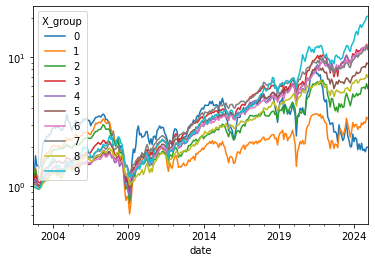

In [ ]:
def returnbyX(df,y='ret',X='value',ngroups=10,plot=True):
    df['X_group']=df.groupby(['date'])[X].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
    ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())
    ret=ret.unstack(level=-1)
    if plot:
        if y=='ret':
            (ret+1).cumprod().plot(logy=True)
        else:
            ret.plot()
    return ret


returnbyX(df,y='ret',X='mom',ngroups=10,plot=True)


## Wrapping all in a function that goes from the Return/market cap data to the final signal-sorted portfolio

 Things to try
 - Play with different look-back windows
 - Play with how many months to skip (1 is the minimum to make the strategy valid. 2 is the standard.)
       - What do you think it will happen if you don't skip and let the signal overlap with the return data?
       - What happens if you skip more months?
 - What happens if you sort only on the month that the standard momentum skips?
 - what if you sort on very long-term momentum, like 60 months?
 - Cumulative returns is just one possible moment to look at
   - What about volatility?
   - What about covariance with the market?
   - What about maximum/minimum return?

In [ ]:
# put it all together in a fuction
def momentum(df,ngroups=10,lookback=11,extraskip=1):
    df['1+ret']=(df['ret']+1)
    df=df.set_index(['date'])
    temp=(df.groupby('permno')[['1+ret']]).rolling(window=lookback,min_periods=lookback).apply(np.prod, raw=True)
    temp=temp.rename(columns={'1+ret':'signal_contemp'})
    temp =temp.reset_index()
    df = pd.merge(df.reset_index(), temp[['permno','date','signal_contemp']], how='left', on=['permno','date'])
    df=df.sort_values(['date','permno'])
    df['me_l1']=df.groupby('permno')['me'].shift(1)
    df['signal']=df.groupby('permno')['signal_contemp'].shift(1+extraskip)
    df=df.dropna(subset=['signal'], how='any')
    ret=returnbyX(df,y='ret',X='signal',ngroups=10,plot=True)

    return ret


X_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2003-01-31,0.009158,-0.033513,-0.012609,-0.035892,-0.030035,-0.028069,-0.027867,-0.015245,-0.004282,-0.015345
2003-02-28,-0.050593,0.016807,-0.014006,-0.019663,-0.027808,-0.013673,-0.019918,-0.019084,-0.011432,0.006978
2003-03-31,0.055390,-0.013165,0.005488,-0.009718,0.022451,0.018792,0.010307,0.009793,0.027086,0.034779
2003-04-30,0.222184,0.159312,0.159679,0.132757,0.083171,0.060253,0.054827,0.056334,0.034029,0.073473
2003-05-31,0.214208,0.189297,0.134637,0.096022,0.073724,0.043873,0.026037,0.047442,0.061743,0.090643
...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.121623,-0.032603,0.001479,-0.024347,0.012539,0.010668,0.031008,0.034119,0.007720,0.045979
2024-09-30,0.019904,0.050513,0.014613,0.052698,0.006031,0.014736,0.019235,0.025015,0.003221,0.043354
2024-10-31,-0.044786,-0.020529,-0.030179,-0.014448,-0.019646,-0.017093,-0.020829,-0.000529,0.005618,0.032594


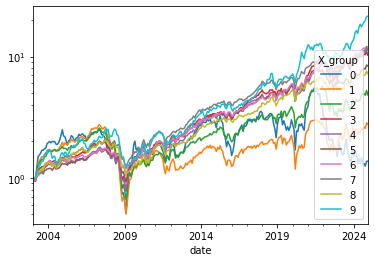

In [ ]:
momentum(crsp,ngroups=10,lookback=11,extraskip=1)


## Return-Based Signals: a summary

1. Long-term reversals
   - DeBondt and Thaler (1985)
   - 3-5 year contrarian strategy

2. Short-term (< 1 month) reversals
   - Jegadeesh (1990), Lehman (1990), Lo andMacKinlay (1988)

3. Intermediate horizon continuation
   - Jegadeesh and Titman (1993)
   - 3-12 month momentum strategy
   - profits dissipate over 1-year and start to reverse after 2-3 years -> temporary price effect.
   - see similar pattern around earnings announcements (both earnings and price momentum).






## Why this might work?


* Behavioral view: The idea here is that markets might be slow to incorporate information, so good/bad news gets into prices slowly over time. For example investors might only slowly get into prices the consequences of a Trump second term.

* Rational view: Maybe all these stocks are exposed to the same missing risk-factor. They all went up and down at the same time after all! For example all firms that went down in march 2020 are particularly exposed to Covid and the ones that did well are positively exposed. So they will move together as COVID risk fluctuate. It is hard to use a story like that to explain the premium, but it is easy to see how it explains the co-movement.

* My overall sense is that the majority of academics think that momentum is driven by "behavioral" factors. Note however that momentum tends to crash very badly in high volatility periods such as 2008 and 2020, so it is certainly risky if you zoom out a bit.

**Literature**

Lots of work on this.

1. [Here is a review of the work on the momentum strategy](https://www.annualreviews.org/doi/full/10.1146/annurev-financial-102710-144850)


2. [Here is the paper that first documented the Momentum profitability](https://www.jstor.org/stable/pdf/2328882.pdf?casa_token=wjU0QYjZvg4AAAAA:aAxgJJLpR7VexgbmcWBBUMveRXin7d5VpGkrYIXDm_UseOs_ETYRZWSNLHzmkGrDFk5A4PNvA6nI8JY4k5khKlSDucppwJ1JNlx0GGqQthOQ4uBY6cA)

3. [Here is Daniel and Moskowitz analysis of momentum](https://github.com/amoreira2/Lectures/blob/a1f2e6ef36e80d32ee12a391b878f564f15c3cd5/assets/papers/Daniel%20Moskowitz%202015.pdf)

## Other "returns" based strategies

One can easily adapt the code to reproduce a variety of investment strategies that only rely on return information, broadly described as "technical" strategies

1. Short-term Reversals: Sort stocks based on returns in month t-1, but in the beginning of month t

2. Long-term reversals: Sort on cumulative returns of the last 5 years

3. Volatility: sort on the return volatility of the last 24 months, say using returns between t-24 to t-1 and form the portfolio in beginning of date t.

4. (HARDER) Market beta: Sort stocks based on their beta with the market portfolio. Say estimate beta using the last 60 months of data (t-60 to t-1) and form portfolio at the beginning of date t.

Below is a plot that summarizes the empirical evidence on return-based strategies. It shows the Sharpe Ratio as a function of the lookback period of the return signal


![image.png](https://github.com/amoreira2/Lectures/raw/main/assets/plots/momentum1.jpg)

* Can you reproduce this plot?


⚡ ⏰ Question: Group D-G ⚡

- Building on a function above, create a for loop that reproduces this plot above.
- Start by telling me what do you want to do
- Then explain how you will get it done

In [ ]:
__=[]
results=pd.DataFrame(index=__)
for __ in __:
  ret=__
  LS=__
  results[_]=__

results.plot()

⚡ ⏰ Question: All groups ⚡

Modify the Momentum function to create a trading strategy that goes long the 10% stocks with lowest volatility in the previous 24 months and goes short the 10% stocks with the highest volatility in the previous 24 months

## 📝 Key Takeaways

*   **Momentum** is a trading strategy that exploits the tendency of past winning stocks to continue performing well and past losing stocks to continue performing poorly.
*   The standard momentum strategy involves ranking stocks based on their cumulative returns over the past 12 months (excluding the most recent month to avoid short-term reversals) and forming portfolios based on these rankings.
*   A key aspect of constructing a valid momentum signal is ensuring there is a time lag between the lookback period for calculating the signal and the holding period of the portfolio to avoid look-ahead bias.
*   Momentum strategies, while historically profitable, can experience significant drawdowns during periods of high market volatility.
*   Return-based strategies are not limited to momentum; other variations include short-term reversals, long-term reversals, and strategies based on volatility or market beta.
*   Constructing these strategies involves defining a signal based on past returns or other historical data, sorting stocks based on this signal, and forming portfolios (e.g., long-short portfolios of the top and bottom quantiles).
*   The empirical evidence suggests varying levels of profitability for different return-based strategies depending on the lookback period and other parameters.